### Introduction
* 지난 시간 동안 우리는 다음 사항에 대해 시행함.
  + torch.nn 모듈의 신경망 레이어와 기능을 사용하여 모델 구축
  + 경사 기반 모델 훈련의 핵심인 자동화된 경사 계산의 메커니즘
  + TensorBoard를 사용하여 훈련 진행 상황 및 기타 활동 시각화
* 여기에서는 인벤토리에 몇 가지 새로운 도구를 추가해보겠음.
  + 데이터 세트 및 데이터 로더 추상화에 대해 알아보고, 훈련 루프 중에 모델에 데이터를 공급하는 프로세스를 쉽게 만드는 방법에 대해 알아봄.
  + 특정 손실 함수와 이를 언제 사용하는지 논의함.
  + 손실 함수의 결과에 따라 모델 가중치를 조정하는 알고리즘을 구현하는 PyTorch 최적화 프로그램을 살펴봄.
* 마지막으로, 이 모든 것을 하나로 모아 전체 PyTorch 훈련 루프가 실제로 작동하는 모습을 살펴봄.

### Dataset and DataLoader
* Dataset 및 DataLoader 클래스는 스토리지에서 데이터를 가져와 훈련 루프에 일괄적으로 노출하는 프로세스를 캡슐화함.
* Dataset는 단일 데이터 인스턴스에 액세스하고 처리하는 일을 담당함.
* DataLoader는 데이터 세트에서 데이터 인스턴스를(자동으로 또는 사용자가 정의한 샘플러를 사용하여)가져와 일괄적으로 수집하고 훈련 루프에서 사용할 수 있도록 반환함.
* DataLoader는 포함된 데이터 유형에 관계없이 모든 종류의 데이터 세트에서 작동함.
* 이 튜토리얼에서는 TorchVision에서 제공하는 Fashion-MNIST 데이터 세트를 사용함.
* 우리는 torchvision.transforms.Normalize()를 사용하여 이미지 타일 콘텐츠의 분포를 0 중심으로 정규화하고 훈련 및 검증 데이터 분할 모두 다운로드함.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5))]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


* 언제나 그렇듯, 온전성 검사를 위해 데이터를 시각화해보겠음.

T-shirt/top  Shirt  Sandal  Bag


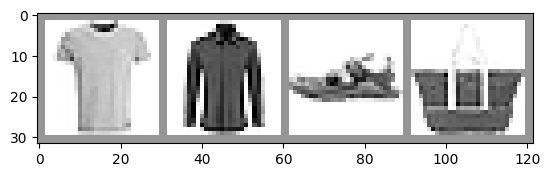

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### The Model
* 이 예에서 사용할 모델은 LeNet-5의 변형임.
* 이 시리즈의 이전 과정을 진행했다면 익숙할 것.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = GarmentClassifier()

### Loss Function
* 이 예에서는 교차 엔트로피 손실을 사용함.
* 시연을 위해 더미 출력 및 레이블 값의 배치를 생성하고 이를 손실 함수를 통해 실행한 후 결과를 검사하겠음.

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB : Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.3058, 0.4620, 0.8058, 0.9188, 0.0721, 0.3206, 0.4815, 0.7775, 0.9349,
         0.6641],
        [0.2958, 0.4890, 0.6584, 0.3886, 0.0575, 0.5723, 0.2529, 0.9757, 0.0984,
         0.0347],
        [0.5007, 0.5906, 0.0508, 0.3366, 0.7498, 0.7810, 0.5829, 0.3311, 0.8627,
         0.6344],
        [0.4660, 0.0909, 0.1756, 0.2788, 0.1820, 0.0980, 0.1620, 0.7324, 0.7044,
         0.4910]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2692384719848633


### Optimizer
* 이 예에서는 운동량을 사용하는 간단한 확률적 경사하강법을 사용함.
* 이 최적화 방식을 몇 가지 변형해 보는 것이 도움이 될 수 있음.
  + 학습률은 최적화 프로그램이 수행하는 단계의 크기를 결정함. 정확도와 수렴 시간 측면에서 학습 속도가 다르면 훈련 결과에 어떤 영향을 미치는지?
  + Momentum은 여러 단계에 걸쳐 가장 강한 기울기 방향으로 최적화 프로그램을 조금씩 움직임. 이 값을 변경하면 결과에 어떤 영향을 미치는지?
  + 평균 SGD, Adagrad 또는 Adam 과 같은 다양한 최적화 알고리즘을 사용해보기. 결과는 어떻게 다른지?

In [5]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop
* 아래에는 하나의 훈련 에포크를 수행하는 함수가 있음.
* DataLoader의 데이터를 열거하고 루프의 각 패스에서 다음을 수행함.
  + DataLoader에서 훈련 데이터 배치를 가져옴.
  + 옵티마이저의 기울기를 0으로 만듦.
  + 추론을 수행함. (즉, 입력 배치에 대한 모델에서 예측을 가져옴.)
  + 해당 예측 세트와 데이터세트의 라벨에 대한 손실을 계산함.
  + 학습 가중치에 대한 역방향 기울기를 계산함.
  + 최적화 프로그램에 하나의 학습 단계를 수행하도록 지시함. (즉, 우리가 선택한 최적화 알고리즘에 따라 이 배치에 대해 관찰된 기울기를 기반으로 모델의 학습 가중치를 조정함.)
  + 1000개 배치마다 손실을 보고함.
  + 마지막으로 검증 실행과 비교하기 위해 마지막 1000개 배치에 대한 평균 배치당 손실을 보고함.

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity
* 에포크당 한 번씩 수행하고 싶은 몇 가지 작업이 있음.
  + 훈련에 사용되지 않은 데이터 세트에 대한 상대적 손실을 확인하여 검증을 수행하고 이를 보고함.
  + 모델 사본 저장함.
* 여기서는 TensorBoard에서 보고를 수행하겠음.
* TensorBoard를 시작하려면 명령줄로 이동하고 다른 브라우저 탭에서 열어야 함.

In [7]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9312215489149094
  batch 2000 loss: 0.9033946783691644
  batch 3000 loss: 0.726324409853667
  batch 4000 loss: 0.6312425659075379
  batch 5000 loss: 0.5966652128899004
  batch 6000 loss: 0.5831051479429007
  batch 7000 loss: 0.5205938018013258
  batch 8000 loss: 0.5188731760135852
  batch 9000 loss: 0.49396122266026216
  batch 10000 loss: 0.47945983507717027
  batch 11000 loss: 0.4487224697736092
  batch 12000 loss: 0.4554383456071373
  batch 13000 loss: 0.44148206407006363
  batch 14000 loss: 0.45414059729955625
  batch 15000 loss: 0.41775117725267774
LOSS train 0.41775117725267774 valid 0.48257148265838623
EPOCH 2:
  batch 1000 loss: 0.4117402998544858
  batch 2000 loss: 0.3908915705666732
  batch 3000 loss: 0.39003376235981707
  batch 4000 loss: 0.3972300202934857
  batch 5000 loss: 0.40435461342913914
  batch 6000 loss: 0.37797154280892575
  batch 7000 loss: 0.3752895968472003
  batch 8000 loss: 0.3797078998180223
  batch 9000 loss: 0.36683227308324423

* 저장된 버전의 모델을 로드하려면

In [9]:
# saved_model = GarmentClassifier()
# saved_model.load_state_dict(torch.load(PATH))

* 모델을 로드하고 나면 추가 교육, 추론, 분석 등 필요한 모든 작업을 수행할 수 있음.
* 모델에 모델 구조에 영향을 미치는 생성자 매개변수가 있는 경우 해당 매개변수를 제공하고 모델이 저장된 상태와 동일하게 모델을 구성해야 함.